### 1. Install R packages

Uncomment section below if running for the first time

In [1]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install("dada2", quiet=TRUE)
# install.packages("magrittr", quiet=TRUE)
# install.packages("stringr", quiet=TRUE)
# install.packages("data.table", quiet=TRUE)
# install.packages("qualpalr", quiet=TRUE)
# install.packages("seqinr", quiet=TRUE)

### 2. Load required libraries

In [2]:
library(dada2, quietly = TRUE)
library(stringr, quietly = TRUE)
library(data.table, quietly = TRUE)
library(qualpalr, quietly = TRUE)
library(ShortRead, quietly = TRUE)
library(Biostrings, quietly = TRUE)
library(seqinr, quietly = TRUE)


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:data.table’:

    first, second


The following objects are masked from ‘package:base’:

    expand.grid, I, unname



Attaching package: ‘IRanges’


The following object is masked from ‘package:data.table’:

    shift



Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit



Attaching package: ‘M

### 3. File path setup

In [3]:
rawpath <- "raw"
wdpath <- "/home/allie/domhain/2022-Diet_oral_microbiome/01-read_processing/" # change to where git repository was cloned
fnFs <- sort(list.files(rawpath, pattern="_R1_001.fastq.gz", full.names=T))
fnRs <- sort(list.files(rawpath, pattern="_R2_001.fastq.gz", full.names=T))
sample.names <- sapply(strsplit(basename(fnFs), "_"), `[`, 1)
head(sample.names, 10)
paste("Number of input samples: ", length(sample.names))

[1] "2L13-PD1" "2L13-PE1" "2L13-PF1" "2L17-PE1" "2L17-PF1" "2L2-PD1" 
 [7] "2L2-PE1"  "2L23-PD1" "2L23-PE1" "2L3-PF1"

[1] "Number of input samples:  266"

### 4. Plot quality scores

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


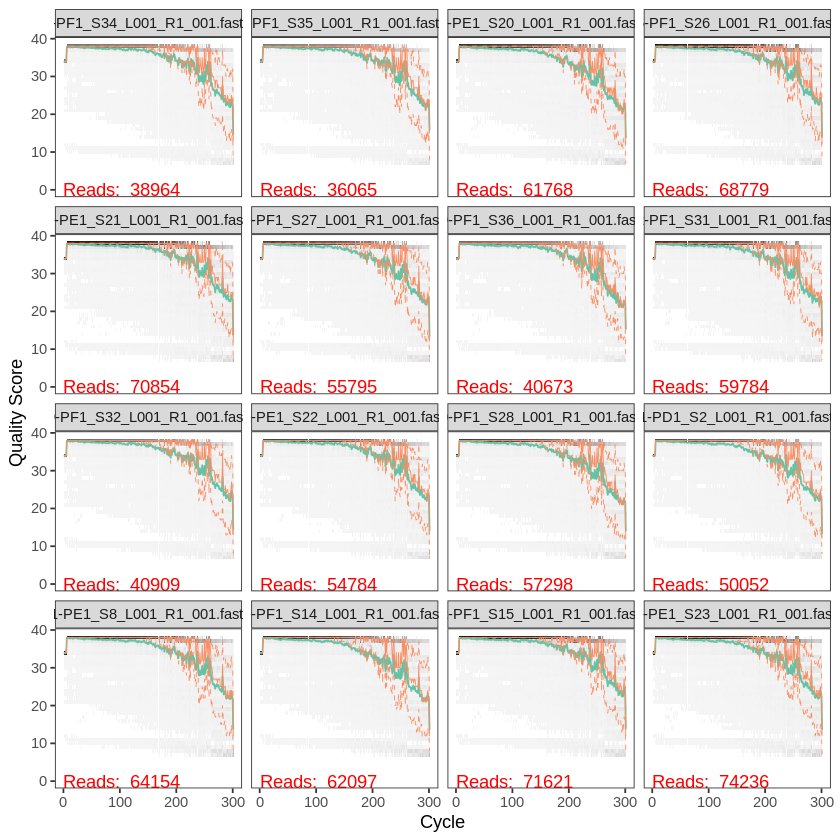

png 
  2

png 
  2

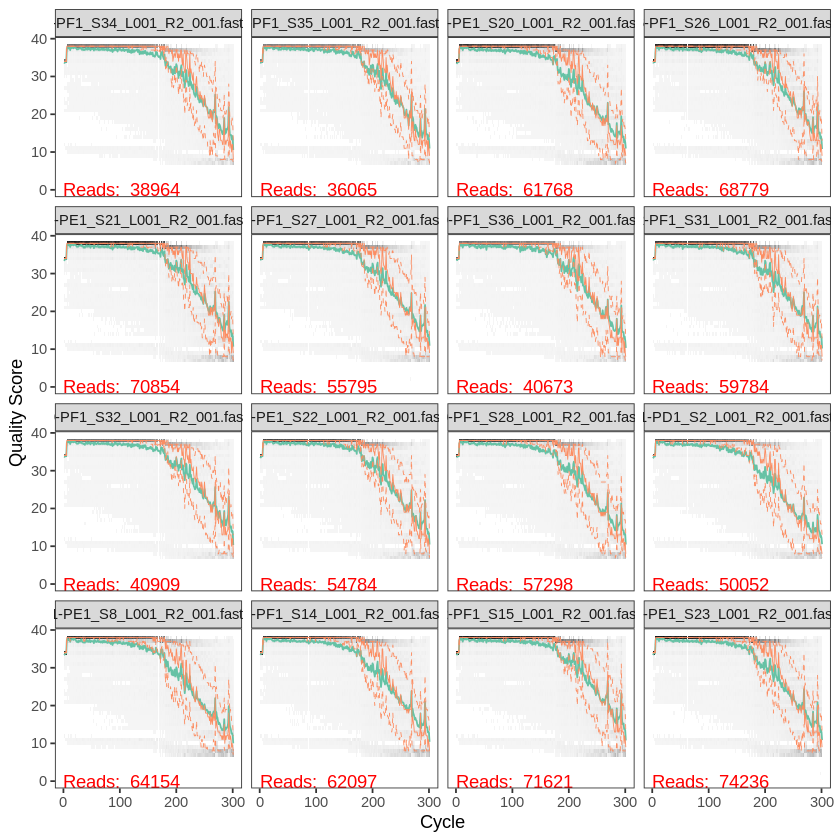

In [4]:
system("mkdir img") # ignore warning
fwdqual <- plotQualityProfile(fnFs[10:25])
revqual <- plotQualityProfile(fnRs[10:25])
fwdqual
revqual

pdf(paste(wdpath, "img/", "forward_quality_plot.pdf", sep=""))
fwdqual
dev.off()
pdf(paste(wdpath, "img/", "reverse_quality_plot.pdf", sep=""))
revqual
dev.off()


### 5. Preliminary filter (removes sequences with uncalled bases)

In [5]:
fnFs.filtN <- file.path(rawpath, "filtN", basename(fnFs)) # Put N-filtered files in filtN/ subdirectory
fnRs.filtN <- file.path(rawpath, "filtN", basename(fnRs))
filterAndTrim(fnFs, fnFs.filtN, fnRs, fnRs.filtN, maxN = 0, multithread = TRUE, compress = TRUE)

### 6. Primer removal 

In [6]:
cutadapt <- as.character(system("which cutadapt", intern=T))
system("cutadapt --version")
path.cut <- file.path(rawpath, "cutadapt")
if(!dir.exists(path.cut)) dir.create(path.cut)
fnFs.cut <- file.path(path.cut, basename(fnFs))
fnRs.cut <- file.path(path.cut, basename(fnRs))
FWD.RC <- dada2:::rc("MAYGARAARMGNATGYTNCARGA")
REV.RC <- dada2:::rc("GMCATYTGRTCNCCRTCRAA")
# Trim FWD and the reverse-complement of REV off of R1 (forward reads)
R1.flags <- paste("-g", "MAYGARAARMGNATGYTNCARGA", "-a", REV.RC) 
# Trim REV and the reverse-complement of FWD off of R2 (reverse reads)
R2.flags <- paste("-G", "GMCATYTGRTCNCCRTCRAA", "-A", FWD.RC) 
for(i in seq_along(fnFs)) {
  system2(cutadapt, args = c("--cores=0", R1.flags, R2.flags, "-n", 2,"-o", fnFs.cut[i], "-p", fnRs.cut[i], fnFs.filtN[i], fnRs.filtN[i]))
}
cutFs <- sort(list.files(path.cut, pattern = "R1", full.names = TRUE))
cutRs <- sort(list.files(path.cut, pattern = "R2", full.names = TRUE))

### 7. Filter and trim reads

In [7]:
filtFs <- file.path(path.cut, "filtered", basename(cutFs))
filtRs <- file.path(path.cut, "filtered", basename(cutRs))
out <- filterAndTrim(cutFs, filtFs, cutRs, filtRs, trimRight=25, maxN=c(0,0), maxEE=c(4,6), rm.phix=TRUE, matchIDs=TRUE, compress=TRUE, multithread=TRUE)
retained <- as.data.frame(out)
retained$percentage_retained <- retained$reads.out/retained$reads.in*100
retained

Creating output directory: raw/cutadapt/filtered



,reads.in,reads.out,percentage_retained
,<dbl>,<dbl>,<dbl>
2L13-PD1_S1_L001_R1_001.fastq.gz,53293,43742,82.07832
2L13-PE1_S7_L001_R1_001.fastq.gz,51802,41455,80.02587
2L13-PF1_S13_L001_R1_001.fastq.gz,50704,44991,88.73264
2L17-PE1_S19_L001_R1_001.fastq.gz,56847,50544,88.91234
2L17-PF1_S25_L001_R1_001.fastq.gz,56009,49541,88.45186
2L2-PD1_S4_L001_R1_001.fastq.gz,50309,40624,80.74897
2L2-PE1_S10_L001_R1_001.fastq.gz,62524,54860,87.74231
2L23-PD1_S5_L001_R1_001.fastq.gz,40489,33113,81.78271
2L23-PE1_S11_L001_R1_001.fastq.gz,60126,48884,81.30260


### 8. Learn and plot error rates

106481298 total bases in 429001 reads from 12 samples will be used for learning the error rates.
109678308 total bases in 435523 reads from 10 samples will be used for learning the error rates.


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


png 
  2

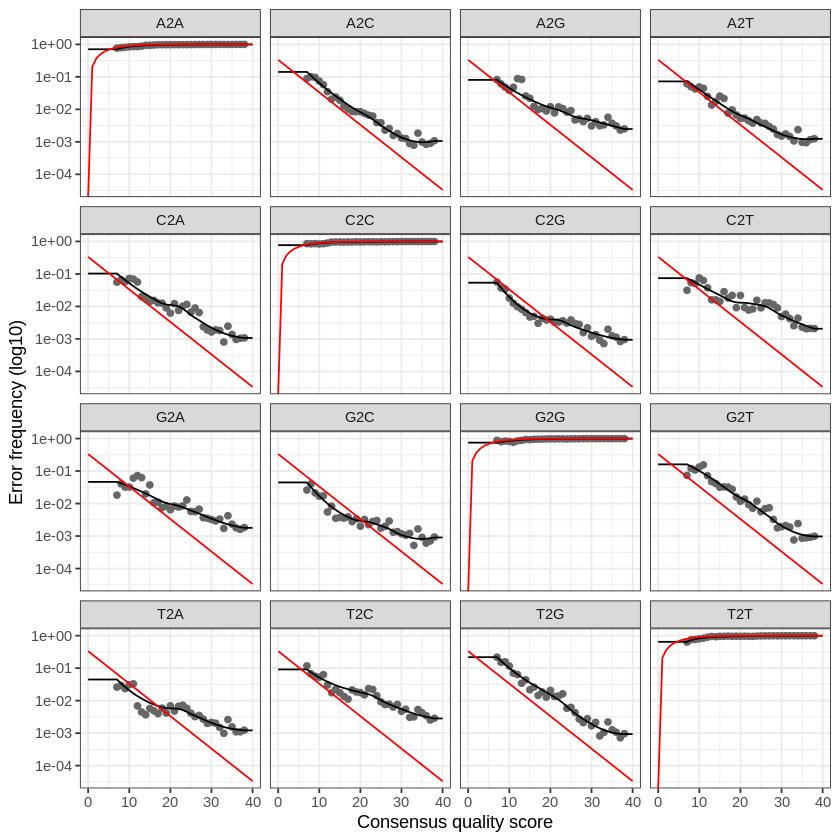

In [8]:
set.seed(12349)
errF <- learnErrors(filtFs, multithread=T, random=T)
errR <- learnErrors(filtRs, multithread=T, random=T)
err.f.plt <- plotErrors(errF, nominalQ=TRUE) 
err.f.plt
pdf(paste(wdpath, "img/", "error_plot.pdf", sep=""))
err.f.plt
dev.off()

### 9. Dereplication

In [9]:
derepFs <- derepFastq(filtFs, verbose=TRUE)
derepRs <- derepFastq(filtRs, verbose=TRUE)
# reassign sample names
sample.names <- sapply(strsplit(basename(filtFs), "_"), `[`, 1)
names(derepFs) <- sample.names
names(derepRs) <- sample.names

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L13-PD1_S1_L001_R1_001.fastq.gz

Encountered 15760 unique sequences from 43742 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L13-PE1_S7_L001_R1_001.fastq.gz

Encountered 15625 unique sequences from 41455 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L13-PF1_S13_L001_R1_001.fastq.gz

Encountered 15843 unique sequences from 44991 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L17-PE1_S19_L001_R1_001.fastq.gz

Encountered 17437 unique sequences from 50544 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L17-PF1_S25_L001_R1_001.fastq.gz

Encountered 17417 unique sequences from 49541 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L2-PD1_S4_L001_R1_001.fastq.gz

Encountered 14119 unique sequences from 4

Encountered 11499 unique sequences from 43693 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00035V1PQ16_S77_L001_R1_001.fastq.gz

Encountered 16746 unique sequences from 72371 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00035V1PQ26_S78_L001_R1_001.fastq.gz

Encountered 16965 unique sequences from 60186 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00036V1PQ51_S79_L001_R1_001.fastq.gz

Encountered 8467 unique sequences from 40547 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00036V1PQ52_S80_L001_R1_001.fastq.gz

Encountered 7948 unique sequences from 26178 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00036V1PQ55_S81_L001_R1_001.fastq.gz

Encountered 20715 unique sequences from 76044 total sequences read.

Dereplicating sequence entries in Fastq file: ra

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00067V1PQ11_S169_L001_R1_001.fastq.gz

Encountered 7111 unique sequences from 27306 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00067V1PQ41_S170_L001_R1_001.fastq.gz

Encountered 13215 unique sequences from 45633 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00067V1PQ75_S171_L001_R1_001.fastq.gz

Encountered 7982 unique sequences from 26677 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00067V1PQ83_S172_L001_R1_001.fastq.gz

Encountered 13304 unique sequences from 48104 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00067V1PQ84_S173_L001_R1_001.fastq.gz

Encountered 11008 unique sequences from 38820 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00068V1PQ53_S174_L001_R1_001.fastq.gz

Enc

Encountered 1640 unique sequences from 5827 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00253V1PQ16_S149_L001_R1_001.fastq.gz

Encountered 3199 unique sequences from 9059 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00254V1PQ64_S151_L001_R1_001.fastq.gz

Encountered 3461 unique sequences from 8961 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00254V1PQ85_S152_L001_R1_001.fastq.gz

Encountered 3025 unique sequences from 8426 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00256V1PQ55_S156_L001_R1_001.fastq.gz

Encountered 2612 unique sequences from 8448 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00259V1PQ26_S159_L001_R1_001.fastq.gz

Encountered 2979 unique sequences from 8621 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cut

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00364V1PQ16_S116_L001_R1_001.fastq.gz

Encountered 16727 unique sequences from 38827 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00371V1PQ26_S125_L001_R1_001.fastq.gz

Encountered 10105 unique sequences from 25057 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00372V1PQ16_S126_L001_R1_001.fastq.gz

Encountered 9778 unique sequences from 26897 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00374V1PQ85_S129_L001_R1_001.fastq.gz

Encountered 7130 unique sequences from 17967 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00381V1PQ55_S136_L001_R1_001.fastq.gz

Encountered 9103 unique sequences from 24590 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00382V1PQ55_S137_L001_R1_001.fastq.gz

Enco

Encountered 8559 unique sequences from 26124 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00491V1PQ16_S98_L001_R1_001.fastq.gz

Encountered 23272 unique sequences from 96785 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00494V1PQ55_S101_L001_R1_001.fastq.gz

Encountered 30003 unique sequences from 134777 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00497V1PQ16_S105_L001_R1_001.fastq.gz

Encountered 22623 unique sequences from 90249 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00499V1PQ16_S107_L001_R1_001.fastq.gz

Encountered 30082 unique sequences from 124068 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00499V1PQ54_S108_L001_R1_001.fastq.gz

Encountered 26190 unique sequences from 117464 total sequences read.

Dereplicating sequence entries in Fastq 

Encountered 31113 unique sequences from 48134 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L49-PF1_S36_L001_R2_001.fastq.gz

Encountered 23102 unique sequences from 34890 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L52-PF1_S31_L001_R2_001.fastq.gz

Encountered 32943 unique sequences from 50357 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L59-PF1_S32_L001_R2_001.fastq.gz

Encountered 21364 unique sequences from 36049 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L60-PE1_S22_L001_R2_001.fastq.gz

Encountered 30268 unique sequences from 47508 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L60-PF1_S28_L001_R2_001.fastq.gz

Encountered 32148 unique sequences from 48543 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/2L6

Encountered 19191 unique sequences from 52549 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00045V1PQ65_S108_L001_R2_001.fastq.gz

Encountered 18417 unique sequences from 50151 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00045V1PQ75_S109_L001_R2_001.fastq.gz

Encountered 18110 unique sequences from 49361 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00046V1PQ26_S110_L001_R2_001.fastq.gz

Encountered 18369 unique sequences from 45868 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00046V1PQ45_S111_L001_R2_001.fastq.gz

Encountered 5057 unique sequences from 11632 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00050V1PQ11_S124_L001_R2_001.fastq.gz

Encountered 25710 unique sequences from 55251 total sequences read.

Dereplicating sequence entries in Fastq fi

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00076V1PQ41_S53_L001_R2_001.fastq.gz

Encountered 14609 unique sequences from 18664 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00077V1PQ31_S54_L001_R2_001.fastq.gz

Encountered 16896 unique sequences from 24001 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00077V1PQ54_S55_L001_R2_001.fastq.gz

Encountered 26665 unique sequences from 41238 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00078V1PQ11_S56_L001_R2_001.fastq.gz

Encountered 25629 unique sequences from 36228 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00078V1PQ32_S57_L001_R2_001.fastq.gz

Encountered 15880 unique sequences from 20632 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00079V1PQ11_S58_L001_R2_001.fastq.gz

Encount

Encountered 7895 unique sequences from 10799 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00273V1PQ16_S180_L001_R2_001.fastq.gz

Encountered 8758 unique sequences from 11063 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00275V1PQ55_S185_L001_R2_001.fastq.gz

Encountered 8458 unique sequences from 10700 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00285V1PQ65_S9_L001_R2_001.fastq.gz

Encountered 24017 unique sequences from 32383 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00286V1PQ55-54_S10_L001_R2_001.fastq.gz

Encountered 33519 unique sequences from 44783 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00294V1PQ55_S20_L001_R2_001.fastq.gz

Encountered 19566 unique sequences from 22706 total sequences read.

Dereplicating sequence entries in Fastq file:

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00425V1PQ31_S4_L001_R2_001.fastq.gz

Encountered 21893 unique sequences from 28682 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00426V1PQ16_S5_L001_R2_001.fastq.gz

Encountered 11635 unique sequences from 20505 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00435V1PQ16_S18_L001_R2_001.fastq.gz

Encountered 22169 unique sequences from 39816 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00435V1PQ85_S19_L001_R2_001.fastq.gz

Encountered 12716 unique sequences from 27246 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00436V1PQ16_S20_L001_R2_001.fastq.gz

Encountered 20003 unique sequences from 39409 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00437V1PQ16_S21_L001_R2_001.fastq.gz

Encounter

Encountered 29385 unique sequences from 57873 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00528V1PQ31_S142_L001_R2_001.fastq.gz

Encountered 42283 unique sequences from 71340 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00529V1PQ55_S143_L001_R2_001.fastq.gz

Encountered 28735 unique sequences from 55244 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00532V1PQ26_S147_L001_R2_001.fastq.gz

Encountered 32117 unique sequences from 66608 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00534V1PQ16_S149_L001_R2_001.fastq.gz

Encountered 37368 unique sequences from 76760 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00538V1PQ16_S156_L001_R2_001.fastq.gz

Encountered 41214 unique sequences from 71367 total sequences read.

Dereplicating sequence entries in Fastq f

### 10. Sample inference

In [10]:
dadaFs <- dada(derepFs, err=errF, multithread=TRUE)
dadaRs <- dada(derepRs, err=errR, multithread=TRUE)

Sample 1 - 43742 reads in 15760 unique sequences.
Sample 2 - 41455 reads in 15625 unique sequences.
Sample 3 - 44991 reads in 15843 unique sequences.
Sample 4 - 50544 reads in 17437 unique sequences.
Sample 5 - 49541 reads in 17417 unique sequences.
Sample 6 - 40624 reads in 14119 unique sequences.
Sample 7 - 54860 reads in 19562 unique sequences.
Sample 8 - 33113 reads in 12002 unique sequences.
Sample 9 - 48884 reads in 17517 unique sequences.
Sample 10 - 33907 reads in 11477 unique sequences.
Sample 11 - 31520 reads in 9845 unique sequences.
Sample 12 - 51051 reads in 19474 unique sequences.
Sample 13 - 61084 reads in 21996 unique sequences.
Sample 14 - 62151 reads in 22558 unique sequences.
Sample 15 - 48134 reads in 18789 unique sequences.
Sample 16 - 34890 reads in 11799 unique sequences.
Sample 17 - 50357 reads in 17515 unique sequences.
Sample 18 - 36049 reads in 12825 unique sequences.
Sample 19 - 47508 reads in 16394 unique sequences.
Sample 20 - 48543 reads in 18416 unique s

Sample 1 - 43742 reads in 31567 unique sequences.
Sample 2 - 41455 reads in 31364 unique sequences.
Sample 3 - 44991 reads in 28391 unique sequences.
Sample 4 - 50544 reads in 30835 unique sequences.
Sample 5 - 49541 reads in 31538 unique sequences.
Sample 6 - 40624 reads in 30425 unique sequences.
Sample 7 - 54860 reads in 32555 unique sequences.
Sample 8 - 33113 reads in 25332 unique sequences.
Sample 9 - 48884 reads in 33234 unique sequences.
Sample 10 - 33907 reads in 20833 unique sequences.
Sample 11 - 31520 reads in 19214 unique sequences.
Sample 12 - 51051 reads in 35285 unique sequences.
Sample 13 - 61084 reads in 37557 unique sequences.
Sample 14 - 62151 reads in 38668 unique sequences.
Sample 15 - 48134 reads in 31113 unique sequences.
Sample 16 - 34890 reads in 23102 unique sequences.
Sample 17 - 50357 reads in 32943 unique sequences.
Sample 18 - 36049 reads in 21364 unique sequences.
Sample 19 - 47508 reads in 30268 unique sequences.
Sample 20 - 48543 reads in 32148 unique 

### 11. Merge paired-end reads

In [11]:
mergers <- mergePairs(dadaFs, derepFs, dadaRs, derepRs, verbose=T)

39934 paired-reads (in 183 unique pairings) successfully merged out of 41689 (in 378 pairings) input.

37602 paired-reads (in 259 unique pairings) successfully merged out of 39846 (in 464 pairings) input.

40465 paired-reads (in 267 unique pairings) successfully merged out of 43208 (in 528 pairings) input.

45784 paired-reads (in 244 unique pairings) successfully merged out of 48954 (in 554 pairings) input.

43969 paired-reads (in 240 unique pairings) successfully merged out of 48132 (in 556 pairings) input.

29581 paired-reads (in 107 unique pairings) successfully merged out of 40050 (in 450 pairings) input.

49817 paired-reads (in 265 unique pairings) successfully merged out of 52705 (in 532 pairings) input.

31176 paired-reads (in 177 unique pairings) successfully merged out of 32044 (in 284 pairings) input.

42956 paired-reads (in 277 unique pairings) successfully merged out of 46157 (in 488 pairings) input.

30481 paired-reads (in 119 unique pairings) successfully merged out of 33

Duplicate sequences in merged output.

47585 paired-reads (in 263 unique pairings) successfully merged out of 48185 (in 331 pairings) input.

49428 paired-reads (in 245 unique pairings) successfully merged out of 50220 (in 332 pairings) input.

54157 paired-reads (in 462 unique pairings) successfully merged out of 55105 (in 619 pairings) input.

43030 paired-reads (in 133 unique pairings) successfully merged out of 43423 (in 160 pairings) input.

46988 paired-reads (in 145 unique pairings) successfully merged out of 47611 (in 203 pairings) input.

55228 paired-reads (in 434 unique pairings) successfully merged out of 56567 (in 596 pairings) input.

32286 paired-reads (in 293 unique pairings) successfully merged out of 32901 (in 377 pairings) input.

53517 paired-reads (in 394 unique pairings) successfully merged out of 54996 (in 539 pairings) input.

50502 paired-reads (in 319 unique pairings) successfully merged out of 51654 (in 445 pairings) input.

44601 paired-reads (in 327 unique 

31811 paired-reads (in 120 unique pairings) successfully merged out of 34418 (in 214 pairings) input.

26151 paired-reads (in 154 unique pairings) successfully merged out of 28083 (in 270 pairings) input.

25791 paired-reads (in 173 unique pairings) successfully merged out of 28107 (in 310 pairings) input.

28422 paired-reads (in 204 unique pairings) successfully merged out of 30373 (in 390 pairings) input.

25722 paired-reads (in 217 unique pairings) successfully merged out of 28306 (in 410 pairings) input.

22770 paired-reads (in 129 unique pairings) successfully merged out of 25433 (in 329 pairings) input.

7531 paired-reads (in 61 unique pairings) successfully merged out of 13697 (in 339 pairings) input.

18294 paired-reads (in 57 unique pairings) successfully merged out of 21684 (in 104 pairings) input.

29633 paired-reads (in 140 unique pairings) successfully merged out of 32119 (in 289 pairings) input.

22181 paired-reads (in 110 unique pairings) successfully merged out of 23933

Duplicate sequences in merged output.

24804 paired-reads (in 255 unique pairings) successfully merged out of 25515 (in 335 pairings) input.

128976 paired-reads (in 1064 unique pairings) successfully merged out of 131792 (in 1747 pairings) input.

161021 paired-reads (in 561 unique pairings) successfully merged out of 165135 (in 922 pairings) input.

140403 paired-reads (in 1017 unique pairings) successfully merged out of 145579 (in 1656 pairings) input.

121334 paired-reads (in 840 unique pairings) successfully merged out of 126408 (in 1380 pairings) input.

41997 paired-reads (in 439 unique pairings) successfully merged out of 44857 (in 614 pairings) input.

68345 paired-reads (in 491 unique pairings) successfully merged out of 69981 (in 740 pairings) input.

54853 paired-reads (in 495 unique pairings) successfully merged out of 56326 (in 781 pairings) input.

61678 paired-reads (in 1234 unique pairings) successfully merged out of 68182 (in 2325 pairings) input.

52333 paired-reads 

### 12. Construct sequence table

In [12]:
seqtab <- makeSequenceTable(mergers)
dim(seqtab)

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.



[1]   266 31651

### 13. Length filter

In [13]:
table(nchar(colnames(seqtab)))


   56    62    63    64    65    66    67    68    69    70    71    72    73 
    1    20    36    34     9    27    33    25    24    49     9    39    16 
   74    75    76    77    78    79    80    81    82    83    84    85    86 
   23    35    35    24    55    34    20    16    37    17    34    60    31 
   87    88    89    90    91    92    93    94    95    96    97    98    99 
   30    42    48    29    52    16    49    43    26    43    27    70    36 
  100   101   102   103   104   105   106   107   108   109   110   111   112 
   25    24    35    58    23    41    26    21    36    19    26    31    46 
  113   114   115   116   117   118   119   120   121   122   123   124   125 
   25    62    43    18    31    34    20    14    24    14    60    57    32 
  126   127   128   129   130   131   132   133   134   135   136   137   138 
   20    79    42    45    33    20    29    23    19    13    33    70    52 
  139   140   141   142   143   144   145   146   1

Filter out any ASVs that are shorter than 450 bp in length

In [14]:
seqlens <- nchar(getSequences(seqtab))
seqtab.filt <- seqtab[,seqlens >= 450]
dim(seqtab.filt)

[1]   266 23654

### 14. Sequence length distribution post filter

11,3,4,2,1,2,9,21,4,17,⋯,423,1,1,2,2,1,112,1,2,2
11,3,4,2,1,2,9,21,4,17,⋯,423,1,1,2,2,1,112,1,2,2
11,3,4,2,1,2,9,21,4,17,⋯,423,1,1,2,2,1,112,1,2,2
11,3,4,2,1,2,9,21,4,17,⋯,423,1,1,2,2,1,112,1,2,2
11,3,4,2,1,2,9,21,4,17,⋯,423,1,1,2,2,1,112,1,2,2
11,3,4,2,1,2,9,21,4,17,⋯,423,1,1,2,2,1,112,1,2,2
11,3,4,2,1,2,9,21,4,17,⋯,423,1,1,2,2,1,112,1,2,2


11,3,4,2,1,2,9,21,4,17,⋯,423,1,1,2,2,1,112,1,2,2
11,3,4,2,1,2,9,21,4,17,⋯,423,1,1,2,2,1,112,1,2,2
11,3,4,2,1,2,9,21,4,17,⋯,423,1,1,2,2,1,112,1,2,2
11,3,4,2,1,2,9,21,4,17,⋯,423,1,1,2,2,1,112,1,2,2
11,3,4,2,1,2,9,21,4,17,⋯,423,1,1,2,2,1,112,1,2,2
11,3,4,2,1,2,9,21,4,17,⋯,423,1,1,2,2,1,112,1,2,2
11,3,4,2,1,2,9,21,4,17,⋯,423,1,1,2,2,1,112,1,2,2


png 
  2

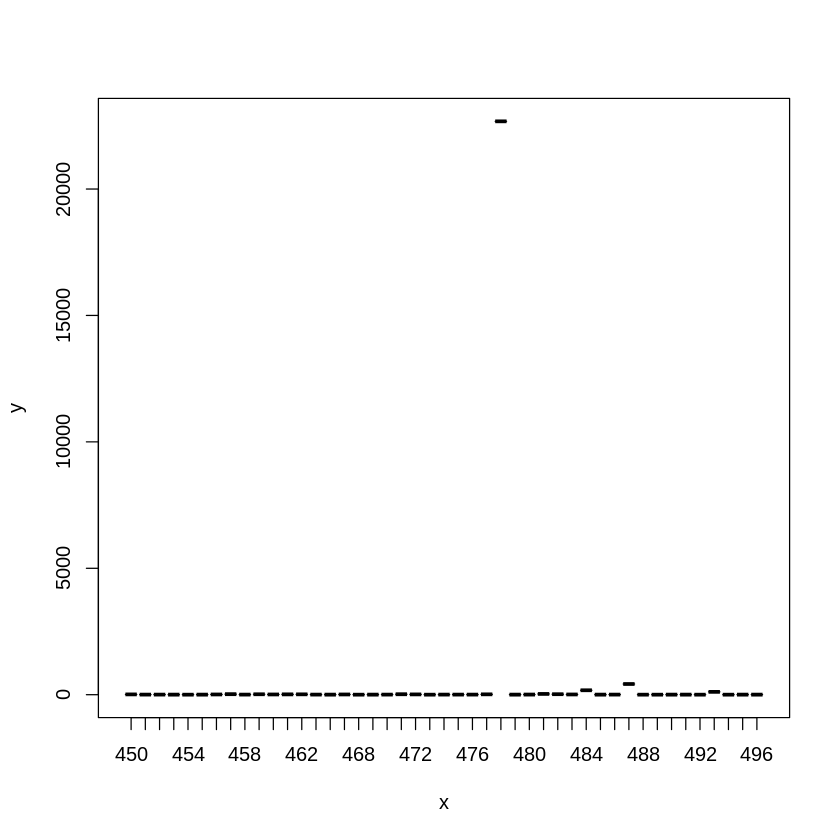

In [15]:
length.histogram <- as.data.frame(table(nchar(getSequences(seqtab.filt))))
len.plt <- plot(x=length.histogram[,1], y=length.histogram[,2])
len.plt
pdf(paste(wdpath, "img/", "length_hist.pdf", sep=""))
len.plt
dev.off()

### 15. Remove chimeras

In [16]:
seqtab.nochim <- removeBimeraDenovo(seqtab.filt, method="pooled", multithread=T, verbose=T)
dim(seqtab.nochim)
sum(seqtab.nochim)/sum(seqtab.filt)

Identified 10576 bimeras out of 23654 input sequences.



[1]   266 13078

[1] 0.9390229

### 16. Processing summary

In [17]:
getN <- function(x) sum(getUniques(x))
track <- cbind(out, sapply(dadaFs, getN), sapply(dadaRs, getN), sapply(mergers, getN), rowSums(seqtab.nochim))
colnames(track) <- c("input", "filtered", "denoisedF", "denoisedR", "merged", "nochimeras")
rownames(track) <- sample.names
track

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.



,input,filtered,denoisedF,denoisedR,merged,nochimeras
2L13-PD1,53293,43742,43191,41889,39934,37623
2L13-PE1,51802,41455,40742,40030,37602,33922
2L13-PF1,50704,44991,44276,43539,40465,37145
2L17-PE1,56847,50544,49918,49240,45784,43075
2L17-PF1,56009,49541,48753,48507,43969,40333
2L2-PD1,50309,40624,40138,40528,29581,28378
2L2-PE1,62524,54860,53921,53040,49817,46099
2L23-PD1,40489,33113,32655,32160,31176,28606
2L23-PE1,60126,48884,47960,46409,42956,39387
2L3-PF1,38961,33907,33627,33359,30481,28434


### 17. Save output

In [18]:
write.table(data.frame("row_names"=rownames(track),track),"read_retention.txt", row.names=FALSE, quote=F, sep="\t")
uniquesToFasta(seqtab.nochim, "rep_set.fa")
system("awk '/^>/{print \">ASV\" ++i; next}{print}' < rep_set.fa > rep_set_fix.fa")
system("mv rep_set_fix.fa rep_set.fa")

### 18. Clean up ASV names

In [19]:
my_otu_table <- t(as.data.frame(seqtab.nochim)) 
ASV.seq <- as.character(unclass(row.names(my_otu_table))) 
ASV.num <- paste0("ASV", seq(ASV.seq), sep='') 
colnames(seqtab.nochim) <- ASV.num 
write.table(data.frame("row_names"=rownames(seqtab.nochim),seqtab.nochim),"sequence_table.merged.txt", row.names=FALSE, quote=F, sep="\t")